In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow_addons.metrics.r_square import RSquare
import matplotlib.pyplot as plt

print('\u2022 Using TensorFlow Version: ', tf.__version__)

• Using TensorFlow Version:  2.8.0


In [2]:
# Folders & Paths
audio_path = './audio/'

features_path = './features/Normalized_Features.csv'

truth_path = './truth/ratings/'
aro_truth_path = truth_path + 'Arousal.csv'
val_truth_path = truth_path + 'Valence.csv'

# Read Feature set data & ground truth for Arousal & Valence

In [3]:
features_norm = pd.read_csv(features_path)
aro_truth = pd.read_csv(aro_truth_path, header=None)
val_truth = pd.read_csv(val_truth_path, header=None)

In [4]:
# Convert to float32 datatype (Meyda js outputs float32 data)
aro_y = aro_truth[1].astype(np.float32)
aro_y

0       0.523495
1       0.211871
2       0.589448
3       0.396538
4       0.764221
          ...   
1208    0.902721
1209    0.655400
1210    0.968673
1211    0.812036
1212    0.927453
Name: 1, Length: 1213, dtype: float32

In [5]:
# Convert to float32 datatype (Meyda js outputs float32 data)
val_y = val_truth[1].astype(np.float32)
val_y

0      -0.767519
1      -0.577906
2      -0.752679
3       0.526793
4      -0.190437
          ...   
1208   -0.952185
1209   -0.742786
1210   -0.965375
1211    0.022259
1212   -0.592745
Name: 1, Length: 1213, dtype: float32

In [6]:
files_list = features_norm['fileName'].tolist()
print(f'Number of files: {len(files_list)}')

Number of files: 1213


# Reduce features to support features available in Meyda js
meyda_available_features = ['rms','zcr','spectralRolloff','spectralCentroid','spectralSpread','spectralSkewness','spectralKurtosis','spectralFlatness','mfcc','chroma','loudness','energy','perceptualSharpness','spectralSlope']

In [7]:
# Meyda extractable features
features = ['rms','zerocross','rolloff','centroid','spread','skewness','kurtosis','flatness','mfcc','chromagram','loudness','energy','perceptual_sharp','spectral_slope']
# meyda_available_features = ['rms','zcr','spectralRolloff','spectralCentroid','spectralSpread','spectralSkewness','spectralKurtosis','spectralFlatness','mfcc','chroma','loudness','energy','perceptualSharpness','spectralSlope']

print(f'Number of features: {len(features)}')

Number of features: 14


In [8]:
# Create list of usable features
mean_str = 'mean'
std_str = 'std'
num_mfcc = 13
num_chroma = 12

chroma_list = []
mfcc_list = []
features_list = [None] * len(features) * 2

mfcc_idx = features.index('mfcc') * 2
chroma_idx = features.index('chromagram') * 2


for i in range(num_chroma):
    chroma_str = f'chromagram_{mean_str}_{str(i+1)}'
    chroma_list.append(chroma_str)

for i in range(num_chroma):
    chroma_str = f'chromagram_{std_str}_{str(i+1)}'
    chroma_list.append(chroma_str)


for i in range(num_mfcc):
    mfcc_str = f'mfcc_{mean_str}_{str(i+1)}'
    mfcc_list.append(mfcc_str)

for i in range(num_mfcc):
    mfcc_str = f'mfcc_{std_str}_{str(i+1)}'
    mfcc_list.append(mfcc_str)

mean_list = [f'{feature}_{mean_str}' for feature in features]
std_list = [f'{feature}_{std_str}' for feature in features]

features_list[::2] = mean_list
features_list[1::2] = std_list

features_list.pop(chroma_idx + 1)
features_list.pop(chroma_idx)
features_list[chroma_idx:chroma_idx] = chroma_list
features_list.pop(mfcc_idx + 1)
features_list.pop(mfcc_idx)
features_list[mfcc_idx:mfcc_idx] = mfcc_list

print(len(features_list))
features_list

74


['rms_mean',
 'rms_std',
 'zerocross_mean',
 'zerocross_std',
 'rolloff_mean',
 'rolloff_std',
 'centroid_mean',
 'centroid_std',
 'spread_mean',
 'spread_std',
 'skewness_mean',
 'skewness_std',
 'kurtosis_mean',
 'kurtosis_std',
 'flatness_mean',
 'flatness_std',
 'mfcc_mean_1',
 'mfcc_mean_2',
 'mfcc_mean_3',
 'mfcc_mean_4',
 'mfcc_mean_5',
 'mfcc_mean_6',
 'mfcc_mean_7',
 'mfcc_mean_8',
 'mfcc_mean_9',
 'mfcc_mean_10',
 'mfcc_mean_11',
 'mfcc_mean_12',
 'mfcc_mean_13',
 'mfcc_std_1',
 'mfcc_std_2',
 'mfcc_std_3',
 'mfcc_std_4',
 'mfcc_std_5',
 'mfcc_std_6',
 'mfcc_std_7',
 'mfcc_std_8',
 'mfcc_std_9',
 'mfcc_std_10',
 'mfcc_std_11',
 'mfcc_std_12',
 'mfcc_std_13',
 'chromagram_mean_1',
 'chromagram_mean_2',
 'chromagram_mean_3',
 'chromagram_mean_4',
 'chromagram_mean_5',
 'chromagram_mean_6',
 'chromagram_mean_7',
 'chromagram_mean_8',
 'chromagram_mean_9',
 'chromagram_mean_10',
 'chromagram_mean_11',
 'chromagram_mean_12',
 'chromagram_std_1',
 'chromagram_std_2',
 'chromagram_s

In [9]:
# filter data to accomodate available features
f_features_norm = features_norm.filter(features_list).astype(np.float32)
print(f_features_norm.dtypes)

rms_mean                 float32
rms_std                  float32
zerocross_mean           float32
zerocross_std            float32
rolloff_mean             float32
                          ...   
energy_std               float32
perceptual_sharp_mean    float32
perceptual_sharp_std     float32
spectral_slope_mean      float32
spectral_slope_std       float32
Length: 74, dtype: object


# Train Deployment Model

### Train Arousal Neural Net

In [10]:
# Arousal Neural Net

aro_model = keras.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(74,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear')
])

aro_model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        MeanSquaredError(),
        RSquare(y_shape=(1,))
    ]
)

In [39]:
aro_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3750      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4,791
Trainable params: 4,791
Non-trainable params: 0
_________________________________________________________________


In [11]:
aro_history = aro_model.fit(f_features_norm, aro_y, epochs=100)

Epoch 1/100
38/38 [==============================] - 1s 1ms/step - loss: 0.3034 - mean_squared_error: 0.3034 - r_square: 0.0893
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 0.2079 - mean_squared_error: 0.2079 - r_square: 0.3760
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1638 - mean_squared_error: 0.1638 - r_square: 0.5085
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1314 - mean_squared_error: 0.1314 - r_square: 0.6056
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1184 - mean_squared_error: 0.1184 - r_square: 0.6447
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1084 - mean_squared_error: 0.1084 - r_square: 0.6746
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1004 - mean_squared_error: 0.1004 - r_square: 0.6988
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 0.0915 - mean_squared_error: 0.

Arousal Model Training History


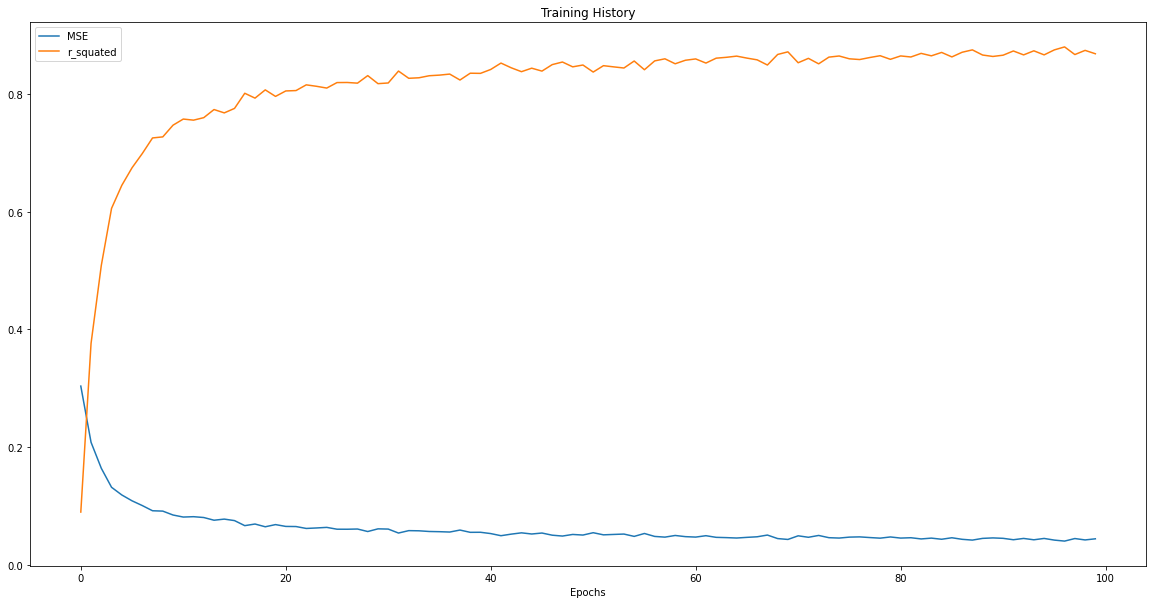

In [12]:
mse = aro_history.history['mean_squared_error']
r2 = aro_history.history['r_square']

epochs = range(len(mse)) # Get number of epochs

#------------------------------------------------
# Plot training MSE per epoch
#------------------------------------------------
plt.figure(figsize=(20,10))
plt.plot  (epochs, mse, label='MSE')

#------------------------------------------------
# Plot training r2 per epoch
#------------------------------------------------
plt.plot  (epochs, r2, label='r_squated')
plt.xlabel('Epochs')
plt.legend()
plt.title ('Training History')

print('Arousal Model Training History')

### Train Valence Neural Net

In [19]:
# Valence Neural Net

val_model = keras.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(74,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear')
])

val_model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        MeanSquaredError(),
        RSquare(y_shape=(1,))
    ]
)

In [40]:
val_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50)                3750      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 20)                1020      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 4,791
Trainable params: 4,791
Non-trainable params: 0
_________________________________________________________________


In [20]:
val_history = val_model.fit(f_features_norm, val_y, epochs=100)

Epoch 1/100
38/38 [==============================] - 0s 1ms/step - loss: 0.3106 - mean_squared_error: 0.3106 - r_square: 0.0682
Epoch 2/100
38/38 [==============================] - 0s 1ms/step - loss: 0.2484 - mean_squared_error: 0.2484 - r_square: 0.2547
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2104 - mean_squared_error: 0.2104 - r_square: 0.3689
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1892 - mean_squared_error: 0.1892 - r_square: 0.4324
Epoch 5/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1770 - mean_squared_error: 0.1770 - r_square: 0.4690
Epoch 6/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1761 - mean_squared_error: 0.1761 - r_square: 0.4716
Epoch 7/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1691 - mean_squared_error: 0.1691 - r_square: 0.4927
Epoch 8/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1576 - mean_squared_error: 0.

Valance Model Training History


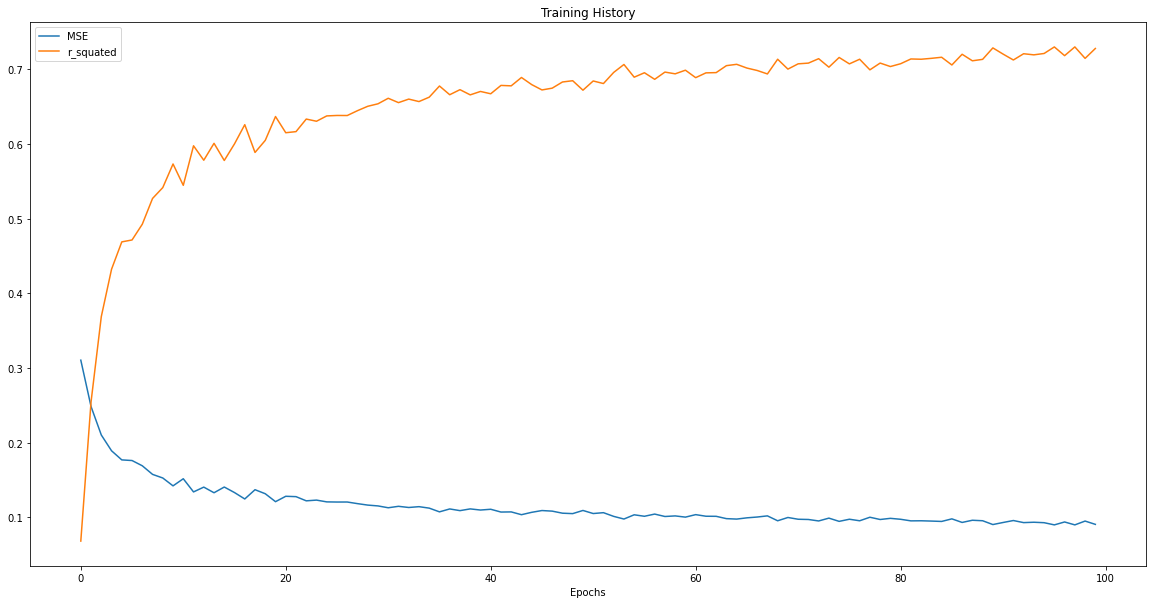

In [21]:
mse = val_history.history['mean_squared_error']
r2 = val_history.history['r_square']

epochs = range(len(mse)) # Get number of epochs

#------------------------------------------------
# Plot training MSE per epoch
#------------------------------------------------
plt.figure(figsize=(20,10))
plt.plot  (epochs, mse, label='MSE')

#------------------------------------------------
# Plot training r2 per epoch
#------------------------------------------------
plt.plot  (epochs, r2, label='r_squated')
plt.xlabel('Epochs')
plt.legend()
plt.title ('Training History')

print('Valence Model Training History')

### Model Metrics
|                    | Arousal | Valence |
| :----------------: | :-----: | :-----: |
|      R Squared     | 0.8684  | 0.7281  |
| Mean Squared Error | 0.0438  | 0.0906  |

# Save Models as Keras HDF5 file

### Save Arousal Model

In [22]:
tf.keras.models.save_model(aro_model, './_models/arousal/aro_model.h5')

### Save Valence Model

In [23]:
tf.keras.models.save_model(val_model, './_models/valence/val_model.h5')

# Convert Models
Run the TensorFlow.js Converter `tensorflowjs_converter` to convert the saved Keras model into JSON format.

### Convert Arousal Model

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    --saved_model_tags=server \
    C:/Users/Kang/Desktop/Thesis/model_training/_models/arousal/aro_model.h5 \
    C:/Users/Kang/Desktop/Thesis/model_training/_models/_output/arousal

### Convert Valence Model

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    --saved_model_tags=server \
    C:/Users/Kang/Desktop/Thesis/model_training/_models/valence/val_model.h5 \
    C:/Users/Kang/Desktop/Thesis/model_training/_models/_output/valence